In [1]:
#Packages to use
import scanpy as sc
import seaborn as sns
import numpy as np
import anndata as ad
import scvi
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import biomart

#Directory to work out of
directory = '/Users/david/Dropbox/RNASeq/HFD'

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [4]:
#Get list of ribosomal genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=WP_CYTOPLASMIC_RIBOSOMAL_PROTEINS&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [5]:
#pre-processing function for each batch
def preprocess(matrix_path,name):
    adata = sc.read_10x_h5(matrix_path)   
    adata.obs['Sample'] = name
    sc.pp.filter_cells(adata, min_counts = 1000) #minimum UMIs per cell
    sc.pp.filter_cells(adata, max_counts = 20000) #maximum UMIs per cell
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.str.lower().isin(ribo_genes[0].str.lower()) # ribosomal genes as 'ribo'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 10] #maximum percentage mt
    adata = adata[adata.obs.pct_counts_ribo < 4] #maximum percentage ribo
    adata.var_names_make_unique()
    adata.var_names_make_unique()
    adata.obs.index=adata.obs['Sample'].to_numpy() + ":" + np.array(adata.obs.index) #make barcodes unique to each batch
    return adata

In [6]:
#perform pre-processing
names = ['HS','CS','HL','CL'] #acronym's we'll use for each group
#A: HS, high-fat short
#B: CS, control short
#C: HL, high-fat long
#D: CL, control long

#the corresponding matrix for each group
files = ['A_raw_feature_bc_matrix.h5','B_raw_feature_bc_matrix.h5','C_raw_feature_bc_matrix.h5','D_raw_feature_bc_matrix.h5']
out = []
for x in range(0,4):
    out.append(preprocess(directory + '/Matrices/' + files[x],names[x]))

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages

In [7]:
#combine all batches
adata = sc.concat(out)
sc.pp.filter_genes(adata, min_cells = 1) #get rid of genes with no counts
adata.X.shape

(38949, 27809)

In [8]:
#convert to sparse matrix
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

In [ ]:
adata.layers['counts'] = adata.X.copy() #save a raw counts version

In [9]:
adata.write_h5ad(directory + '/combined.h5ad')

In [2]:
adata = sc.read_h5ad(directory + '/combined.h5ad')
adata.obs.index

Index(['HS:AAACCCAAGGAGCAAA-1', 'HS:AAACCCAAGTGCAGGT-1',
       'HS:AAACCCACAAATCGGG-1', 'HS:AAACCCACAGACATCT-1',
       'HS:AAACCCACAGCTCGGT-1', 'HS:AAACCCACAGCTGAGA-1',
       'HS:AAACCCACAGGGACTA-1', 'HS:AAACCCAGTCTGCAAT-1',
       'HS:AAACCCAGTTTGACAC-1', 'HS:AAACCCATCACCCATC-1',
       ...
       'CL:TTTGGTTGTCCAGCAC-1', 'CL:TTTGGTTGTTGCTCCT-1',
       'CL:TTTGGTTTCATTTGGG-1', 'CL:TTTGGTTTCCGTGTAA-1',
       'CL:TTTGTTGAGCGACCCT-1', 'CL:TTTGTTGAGTCACAGG-1',
       'CL:TTTGTTGCACAGCTTA-1', 'CL:TTTGTTGCAGACCCGT-1',
       'CL:TTTGTTGCATTACTCT-1', 'CL:TTTGTTGGTTTACTGG-1'],
      dtype='object', length=38949)

In [5]:
#get highly variable genes for gene expression similarity analysis
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer='counts', flavor = 'seurat_v3', batch_key='Sample')
adata.X.shape

(38949, 2000)

In [6]:
#setup scVI model
scvi.model.SCVI.setup_anndata(adata, layer = 'counts',
                             batch_key='Sample')
model = scvi.model.SCVI(adata)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [12]:
#train model
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 205/205: 100%|███████| 205/205 [20:15<00:00,  5.64s/it, loss=633, v_num=1]

`Trainer.fit` stopped: `max_epochs=205` reached.


Epoch 205/205: 100%|███████| 205/205 [20:15<00:00,  5.93s/it, loss=633, v_num=1]


In [13]:
#save latent variables
adata.obsm['X_scVI'] = model.get_latent_representation()

In [ ]:
#doublet detection function
def doubdetect(name):
    solo_batch = scvi.external.SOLO.from_scvi_model(model, restrict_to_batch=name)
    solo_batch.train()
    bp = solo_batch.predict()
    return bp

In [ ]:
#perform doublet detection
names = ['HS','CS','HL','CL']
out = []
for x in range(0,4):
    out.append(doubdetect(names[x]))

In [18]:
#identify doublet barcodes
dps = pd.concat(out,axis=0)
dps['isdoublet']=dps['doublet']>dps['singlet']

In [19]:
#remove doublets
adata=adata[dps['isdoublet']==False]
adata.X.shape

(34322, 2000)

In [4]:
adata.write_h5ad(directory + '/integrated.h5ad')

In [7]:
adata = sc.read_h5ad(directory + '/combined.h5ad')
adata_scvi = sc.read_h5ad(directory + '/integrated.h5ad')

In [8]:
#remove doublets and save latent variables to original matrix (with all genes)
barcodes_inc = adata_scvi.obs.index
adata = adata[adata.obs.index.isin(barcodes_inc)]
adata.obsm['X_scVI'] = adata_scvi.obsm['X_scVI']

In [10]:
adata.X.shape

(34322, 27809)

In [12]:
#calculate nearest neighbors
sc.pp.neighbors(adata, use_rep = 'X_scVI', n_neighbors=50)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


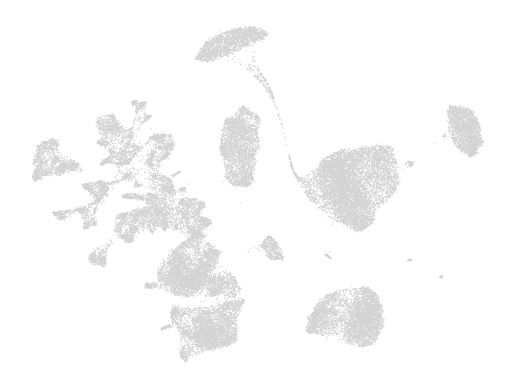

In [13]:
#calculate UMAP
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, frameon = False)

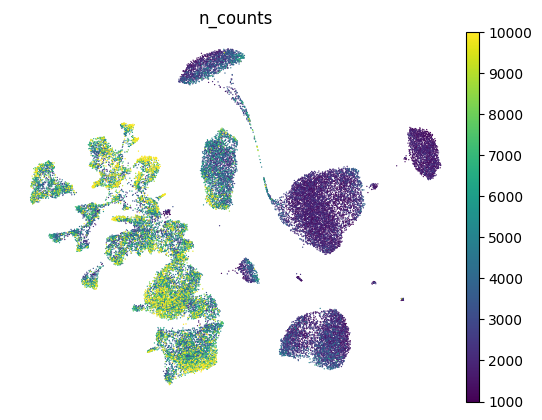

In [15]:
sc.pl.umap(adata, color = ['n_counts'], frameon = False, vmax = 10000)

In [16]:
#cluster for cell-typing
sc.tl.leiden(adata, resolution = 0.1)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


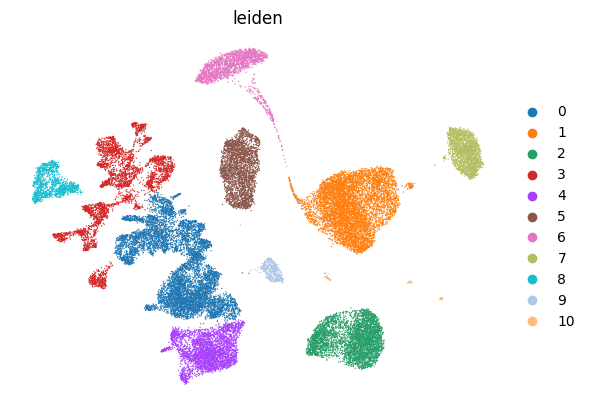

In [17]:
sc.pl.umap(adata, color = ['leiden'], frameon = False)

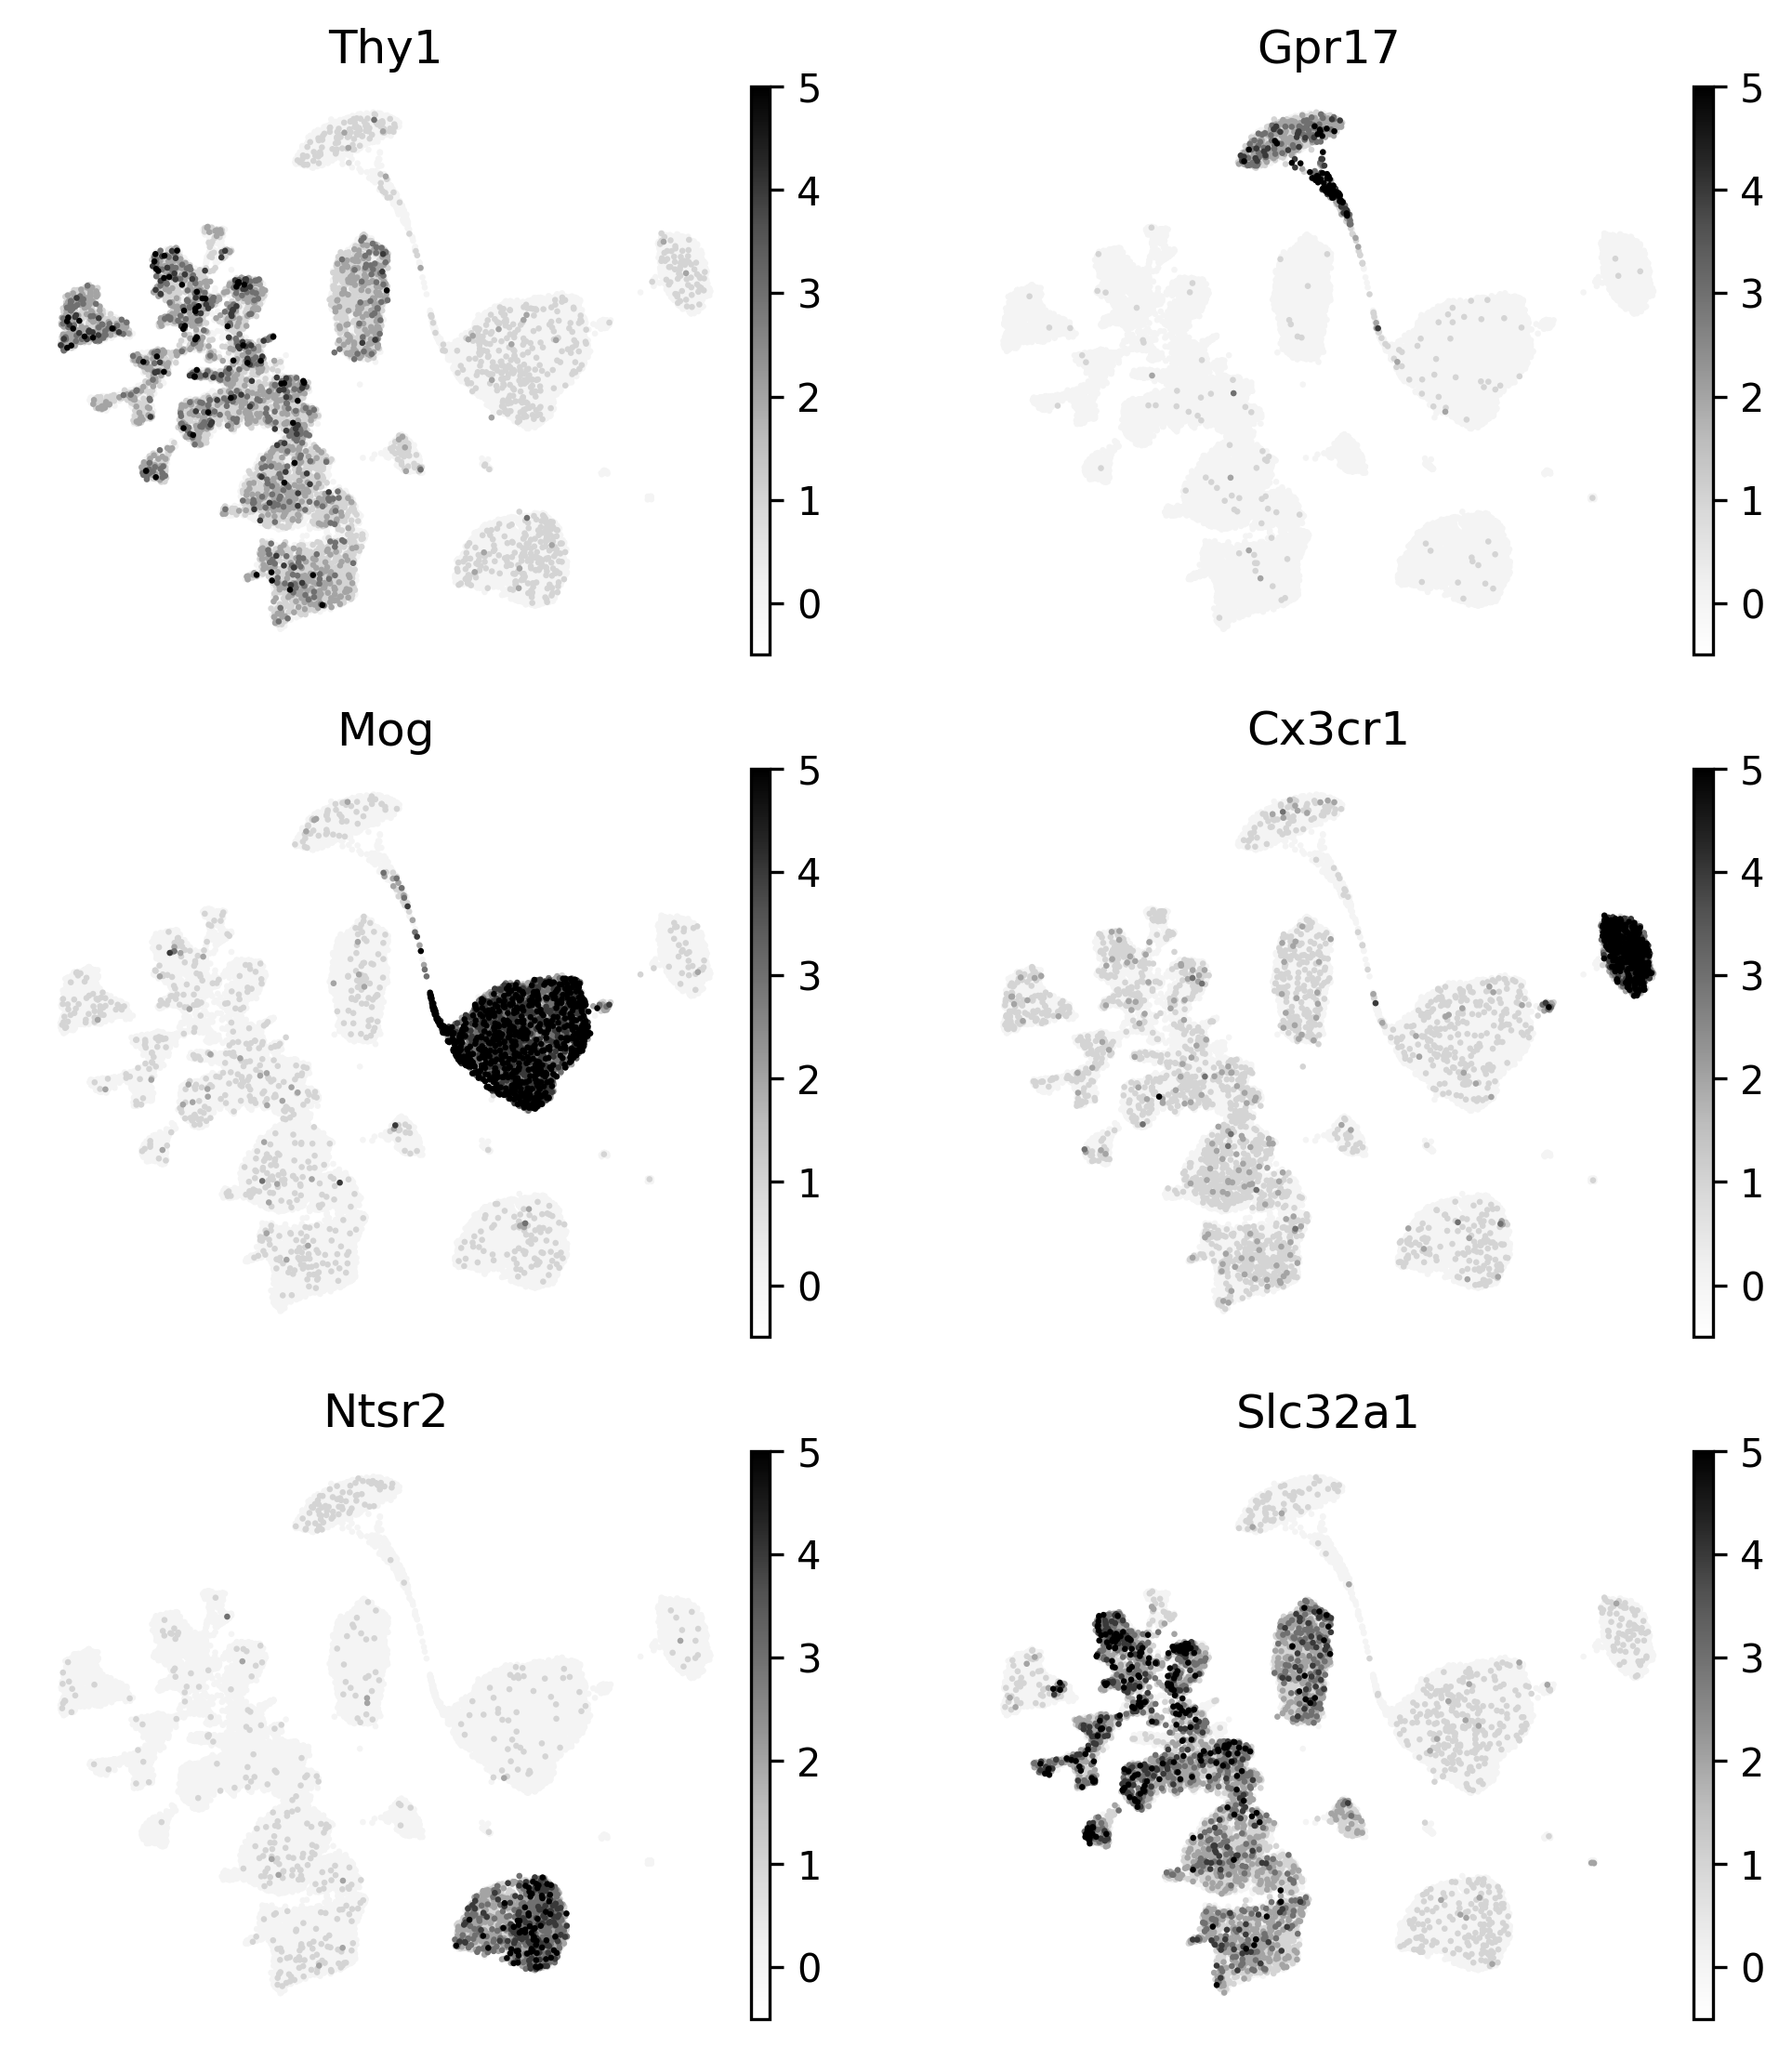

In [59]:
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata, color = ['Thy1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,2)
um = sc.pl.umap(adata, color = ['Gpr17'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,3)
um = sc.pl.umap(adata, color = ['Mog'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,4)
um = sc.pl.umap(adata, color = ['Cx3cr1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,5)
um = sc.pl.umap(adata, color = ['Ntsr2'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,6)
um = sc.pl.umap(adata, color = ['Slc32a1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
plt.savefig(directory + '/Figures/cellsExpression.png')

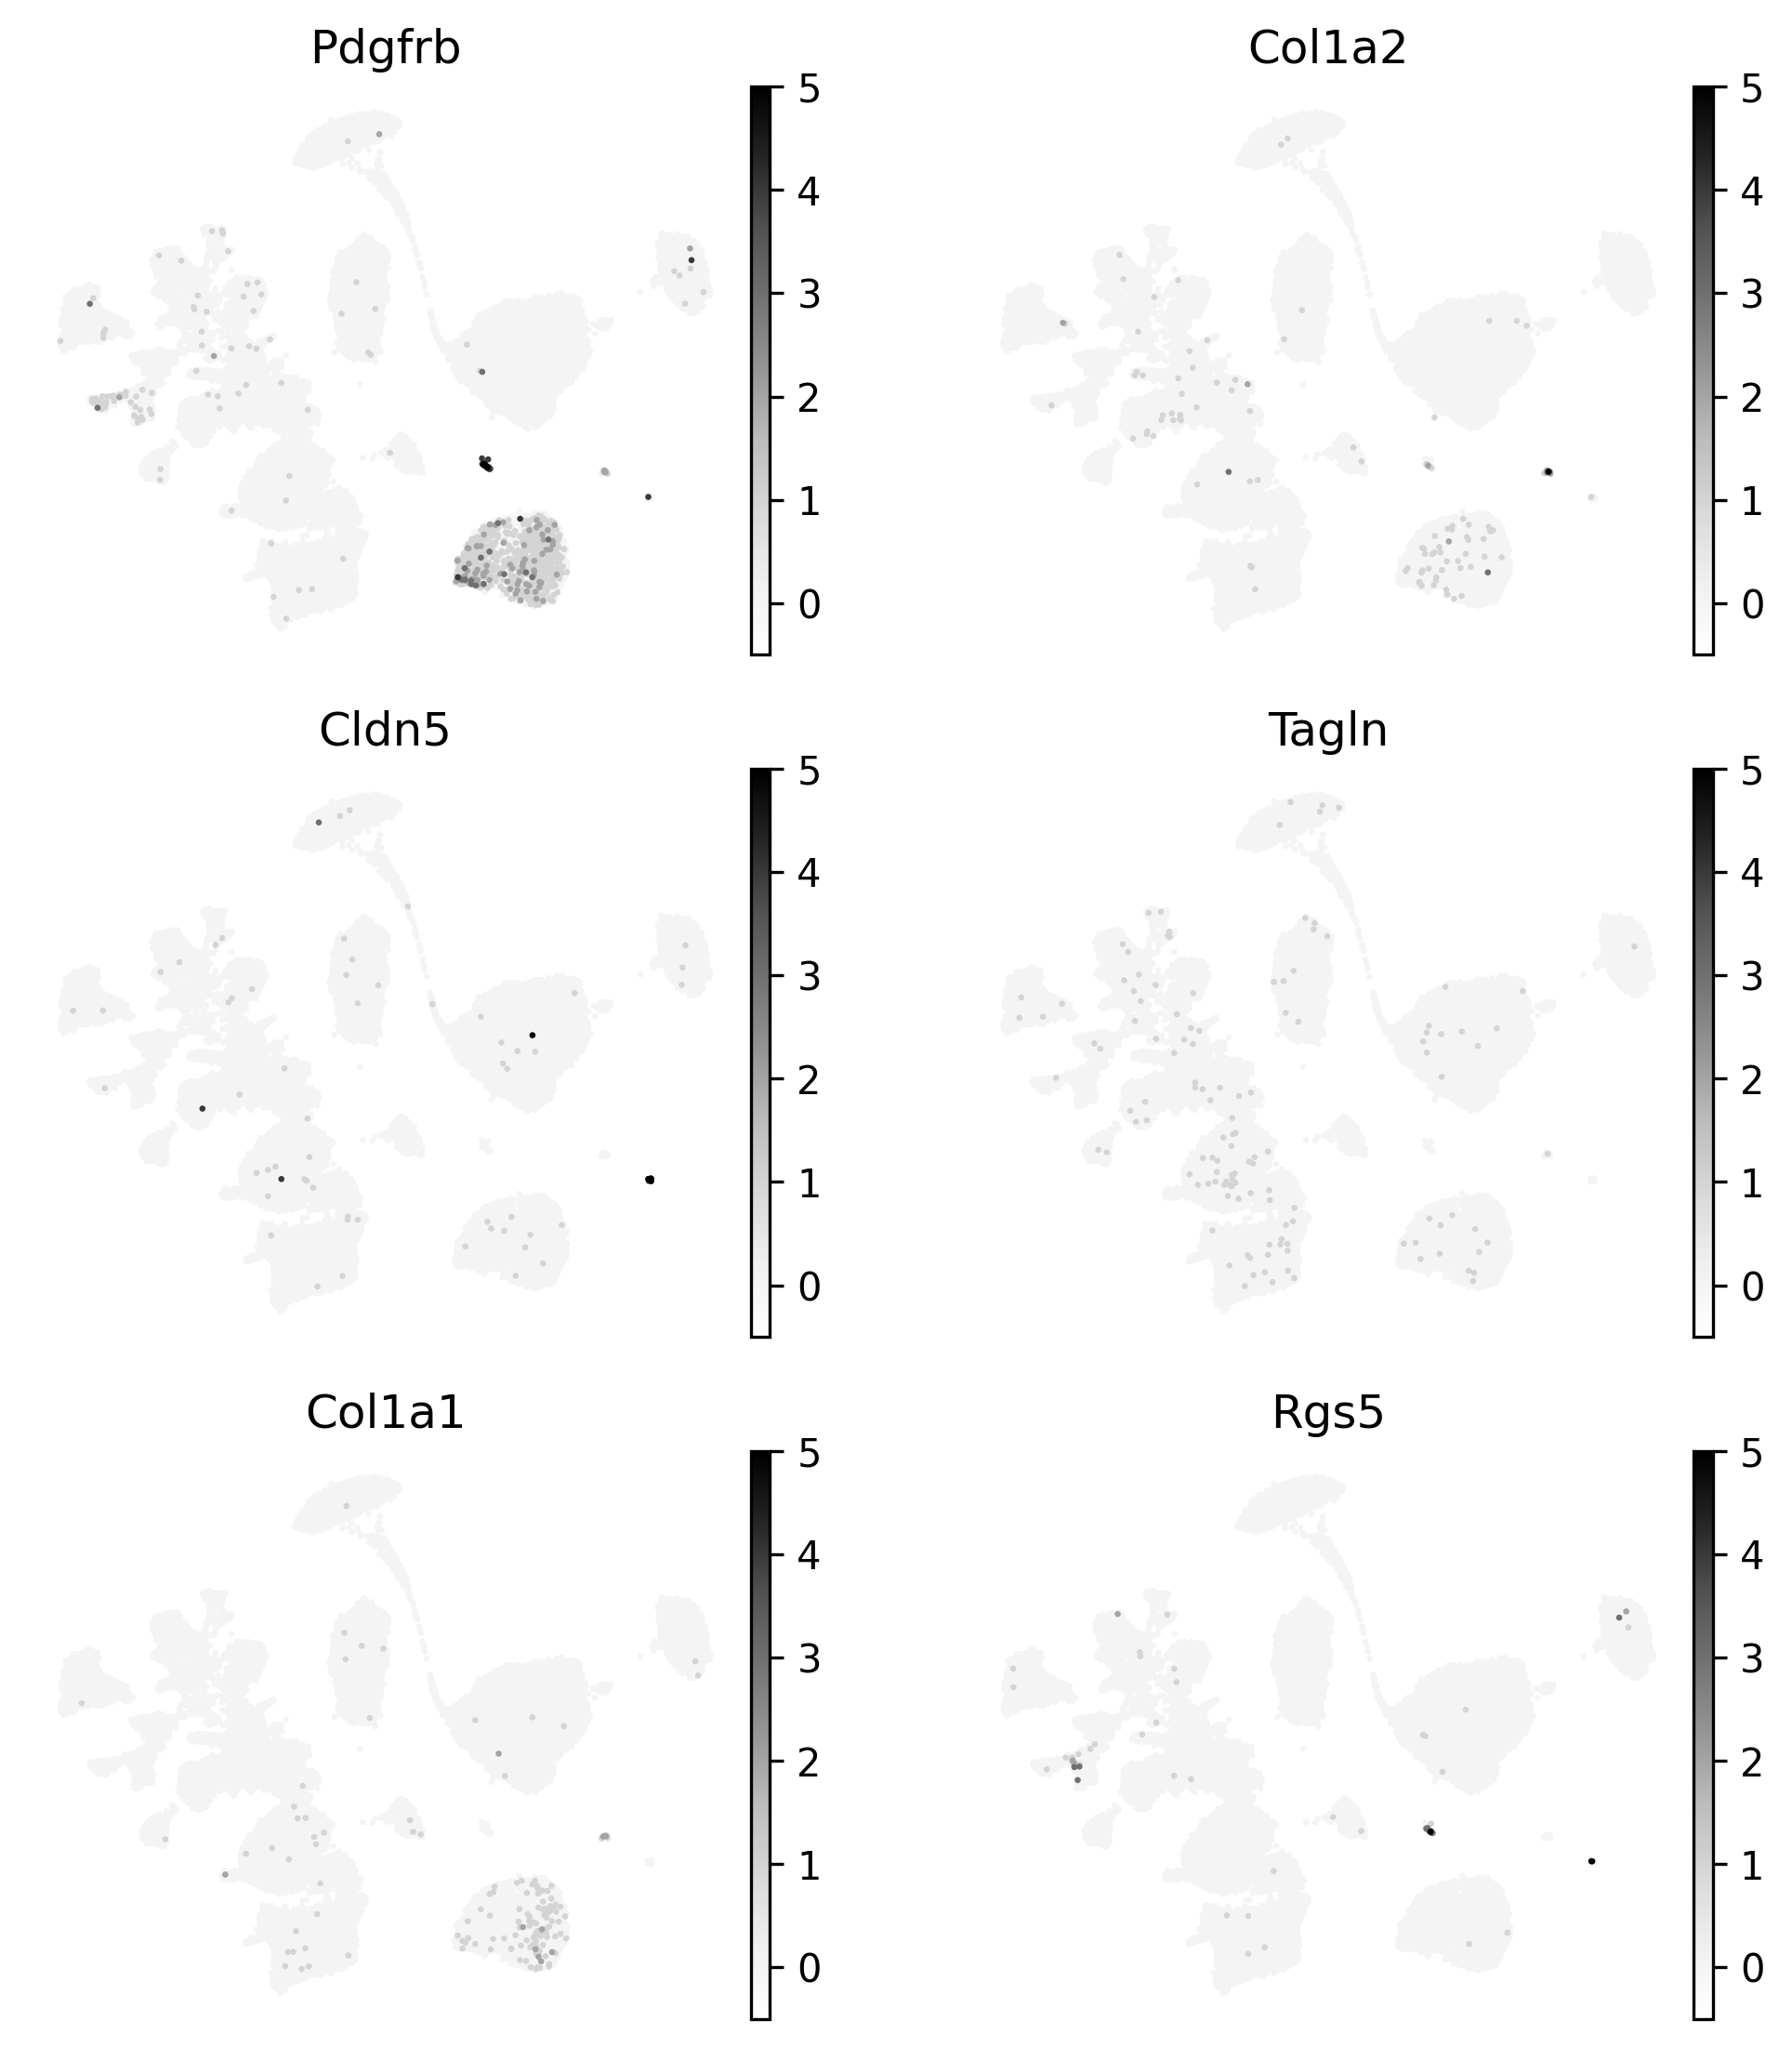

In [60]:
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)

#pericyte
um = sc.pl.umap(adata, color = ['Pdgfrb'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,2)

#fibroblast
um = sc.pl.umap(adata, color = ['Col1a2'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,3)

#endothelial
um = sc.pl.umap(adata, color = ['Cldn5'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,4)
um = sc.pl.umap(adata, color = ['Tagln'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,5)
um = sc.pl.umap(adata, color = ['Col1a1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,6)
um = sc.pl.umap(adata, color = ['Rgs5'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
plt.savefig(directory + '/Figures/cellsExpression2.png')

In [18]:
#map clusters into cell types
cell_type = {"0":"Neurons",
             "1":"Oligodendrocytes",
"2":"Astrocytes",
"3":"Neurons",
"4":"Neurons",
"5":"Neurons",
"6":"Oligo. precursor cells",
"7":"Microglia",
"8":"Neurons",
"9":"Neurons",
"10":"Fibr./Pericyte/Endothel.", 
}

adata.obs['celltype'] = adata.obs.leiden.map(cell_type)

In [19]:
ctcolors = {"Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.86, 0.52, 0.83),
            "Astrocytes":(0.58, 0.73, 0.94),
            "Oligo. precursor cells":(0.97, 0.62, 0.62),
            "Microglia":(0.97, 0.8, 0.55),
            "Fibr./Pericyte/Endothel.":(0.97, 0.93, 0.68),
           }

In [20]:
plt.rcParams['figure.dpi'] = 300

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


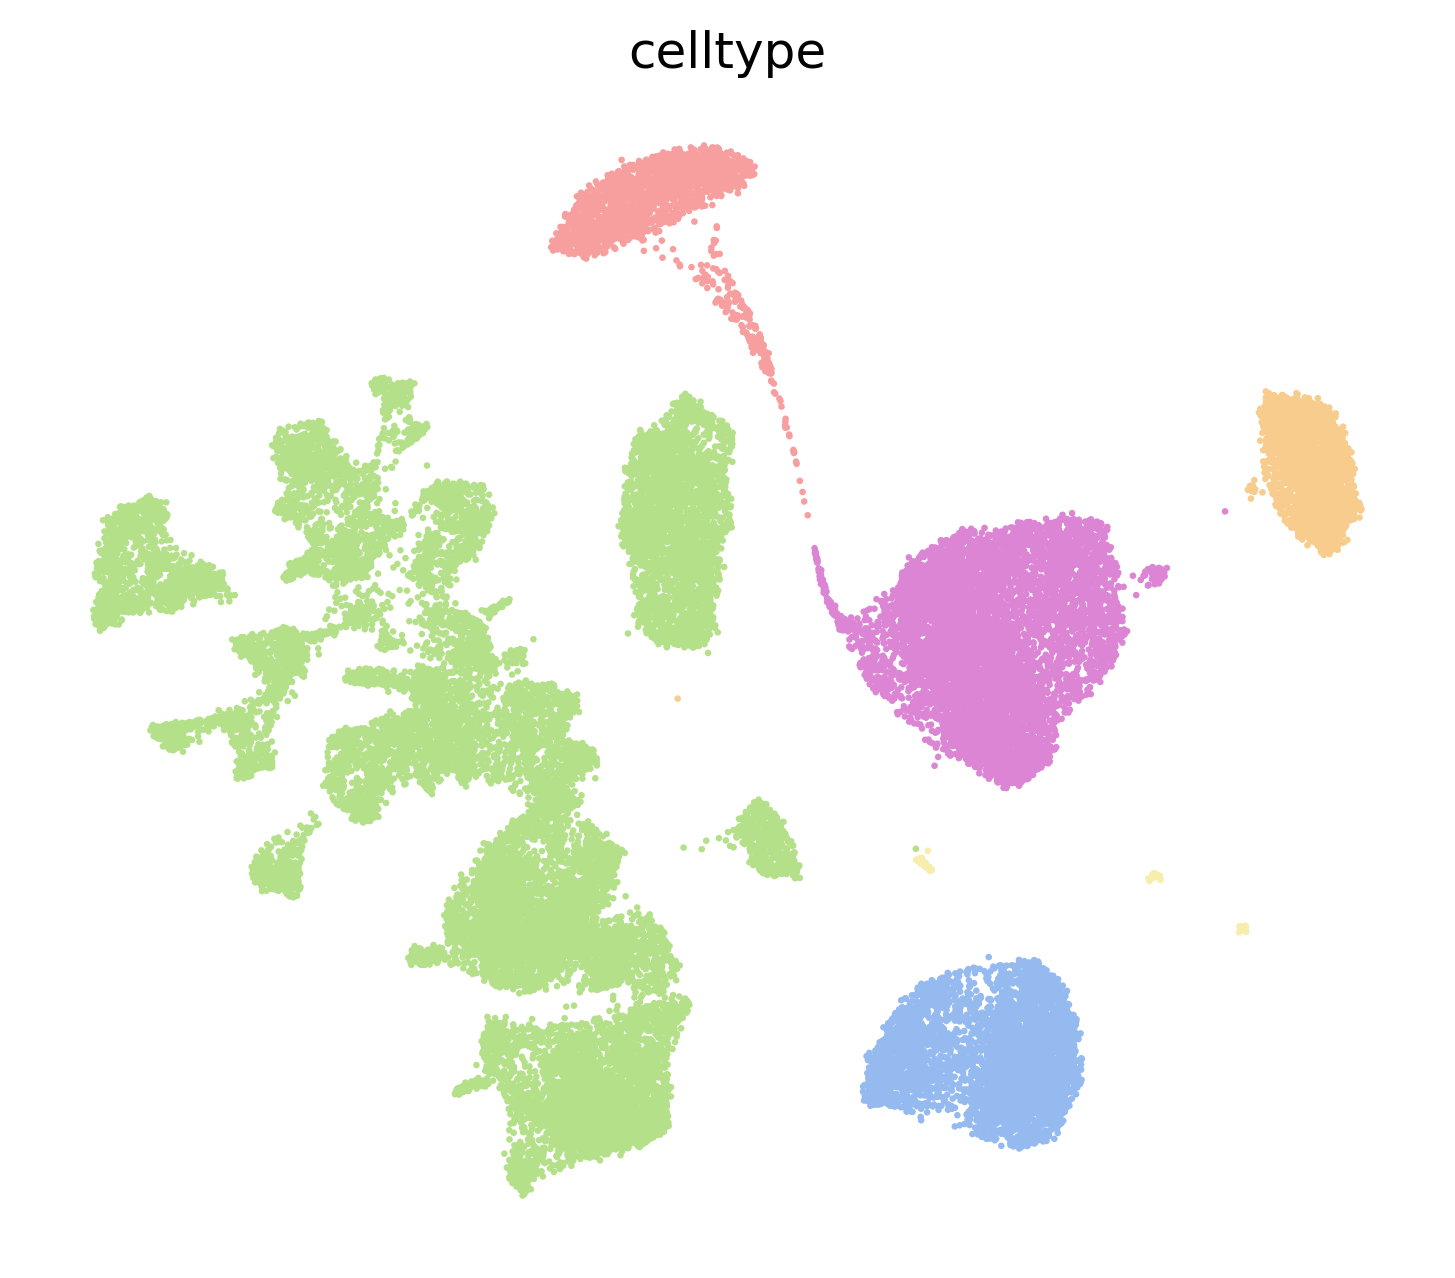

In [21]:
plt.figure(figsize = (6,5))
um = plt.subplot(1,1,1)
um = sc.pl.umap(adata, color = ['celltype'], frameon = False, size=10, ax = um, palette = ctcolors, show=False, legend_loc='off right')
plt.savefig(directory + '/Figures/cellsUMAP.png')

In [57]:
ctcolorsN = {"Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.8, 0.8, 0.8),
            "Astrocytes":(0.8, 0.8, 0.8),
            "Oligo. precursor cells":(0.8, 0.8, 0.8),
            "Microglia":(0.8, 0.8, 0.8),
            "Fibr./Pericyte/Endothel.":(0.8, 0.8, 0.8),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


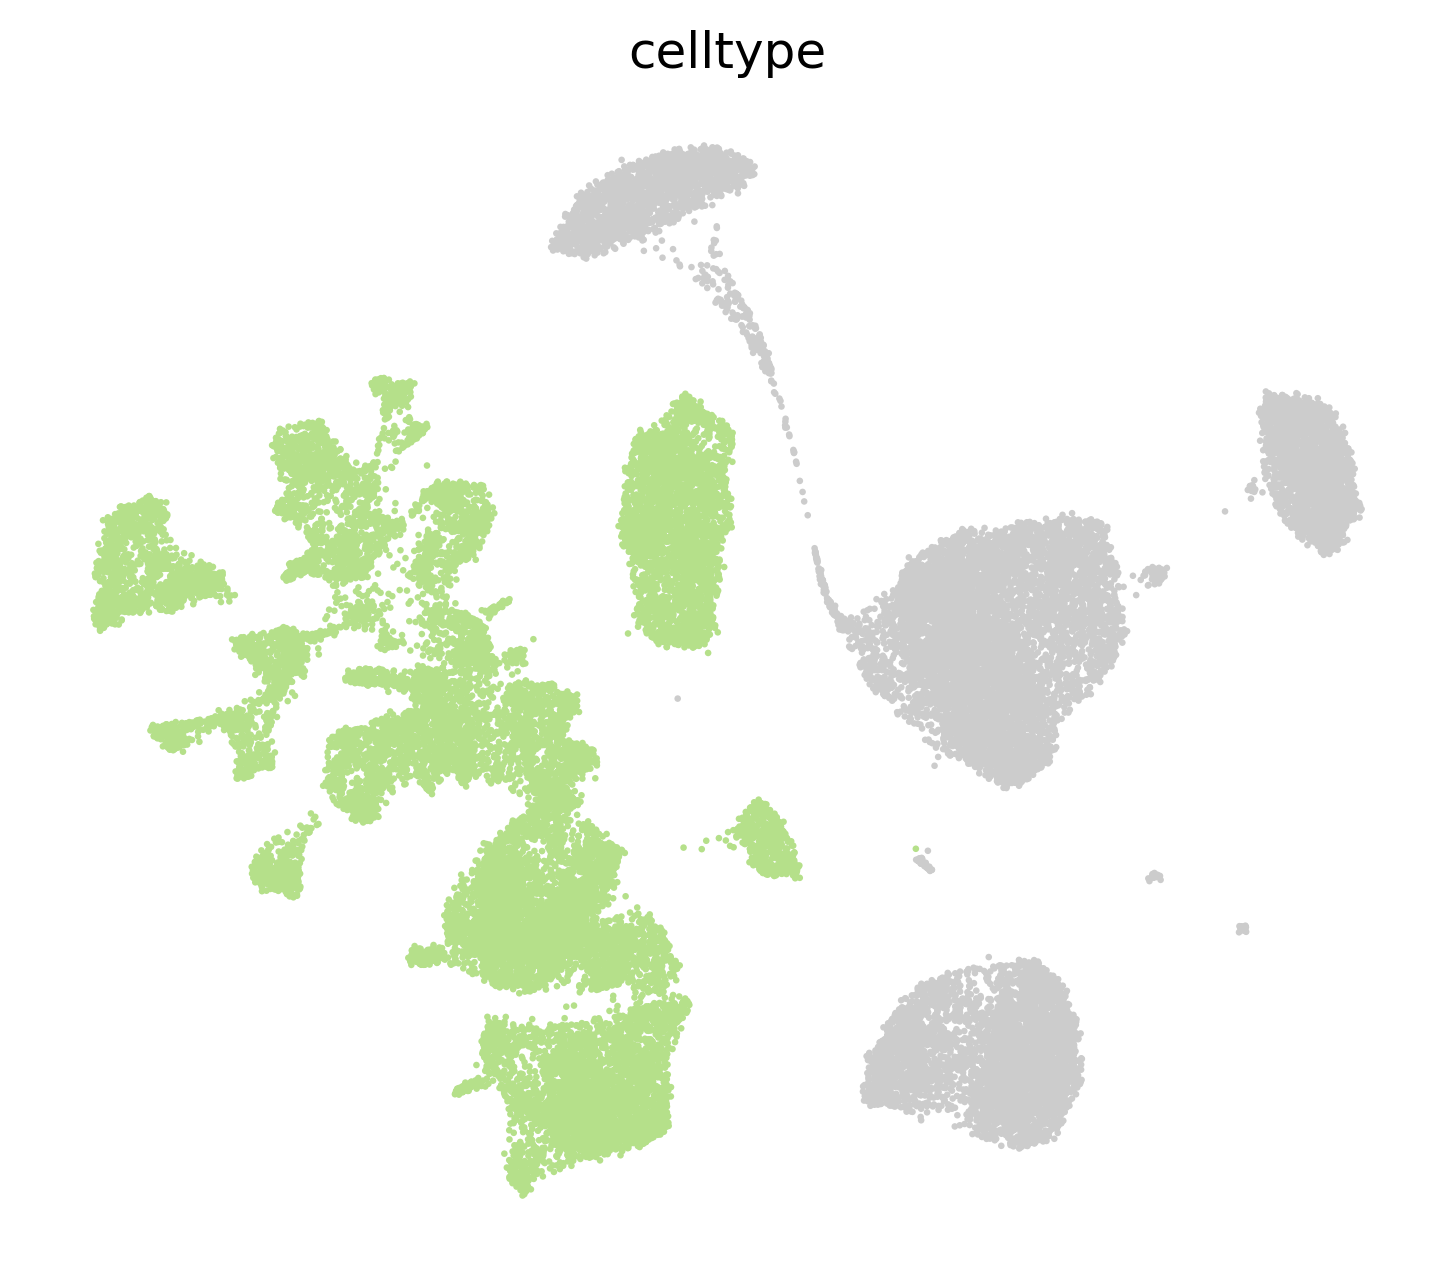

In [58]:
plt.figure(figsize = (6,5))
um = plt.subplot(1,1,1)
um = sc.pl.umap(adata, color = ['celltype'], frameon = False, size=10, ax = um, palette = ctcolorsN, show=False, legend_loc='off right')
plt.savefig(directory + '/Figures/cellsUMAPN.png')

In [61]:
gpcolors = {"CL":np.divide((106, 106, 106),256),
            "CS":np.divide((175, 175, 175),256),
            "HL":np.divide((148, 35, 236),256),
            "HS":np.divide((208, 158, 247),256),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


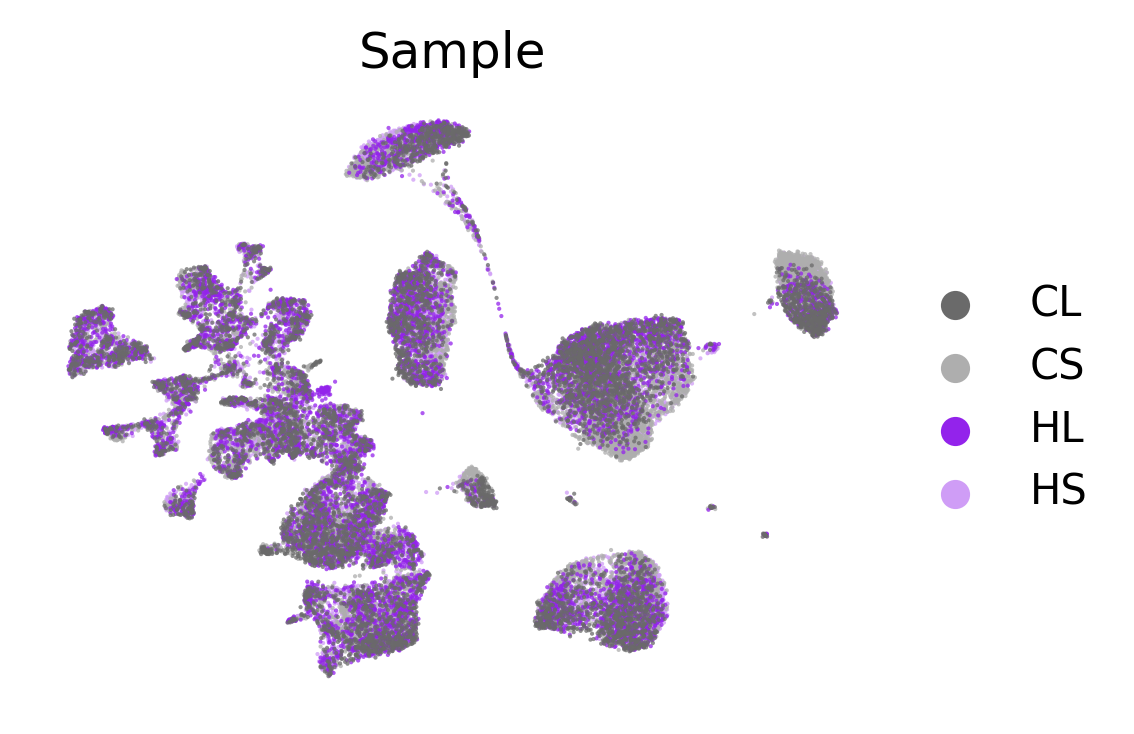

In [62]:
#color by batch
kwargs = {'alpha': 0.75}
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata, color = ['Sample'], frameon = False,
                size=4, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                show=False, palette = gpcolors, **kwargs)
plt.savefig(directory + '/Figures/cellsGroupUMAP.png')

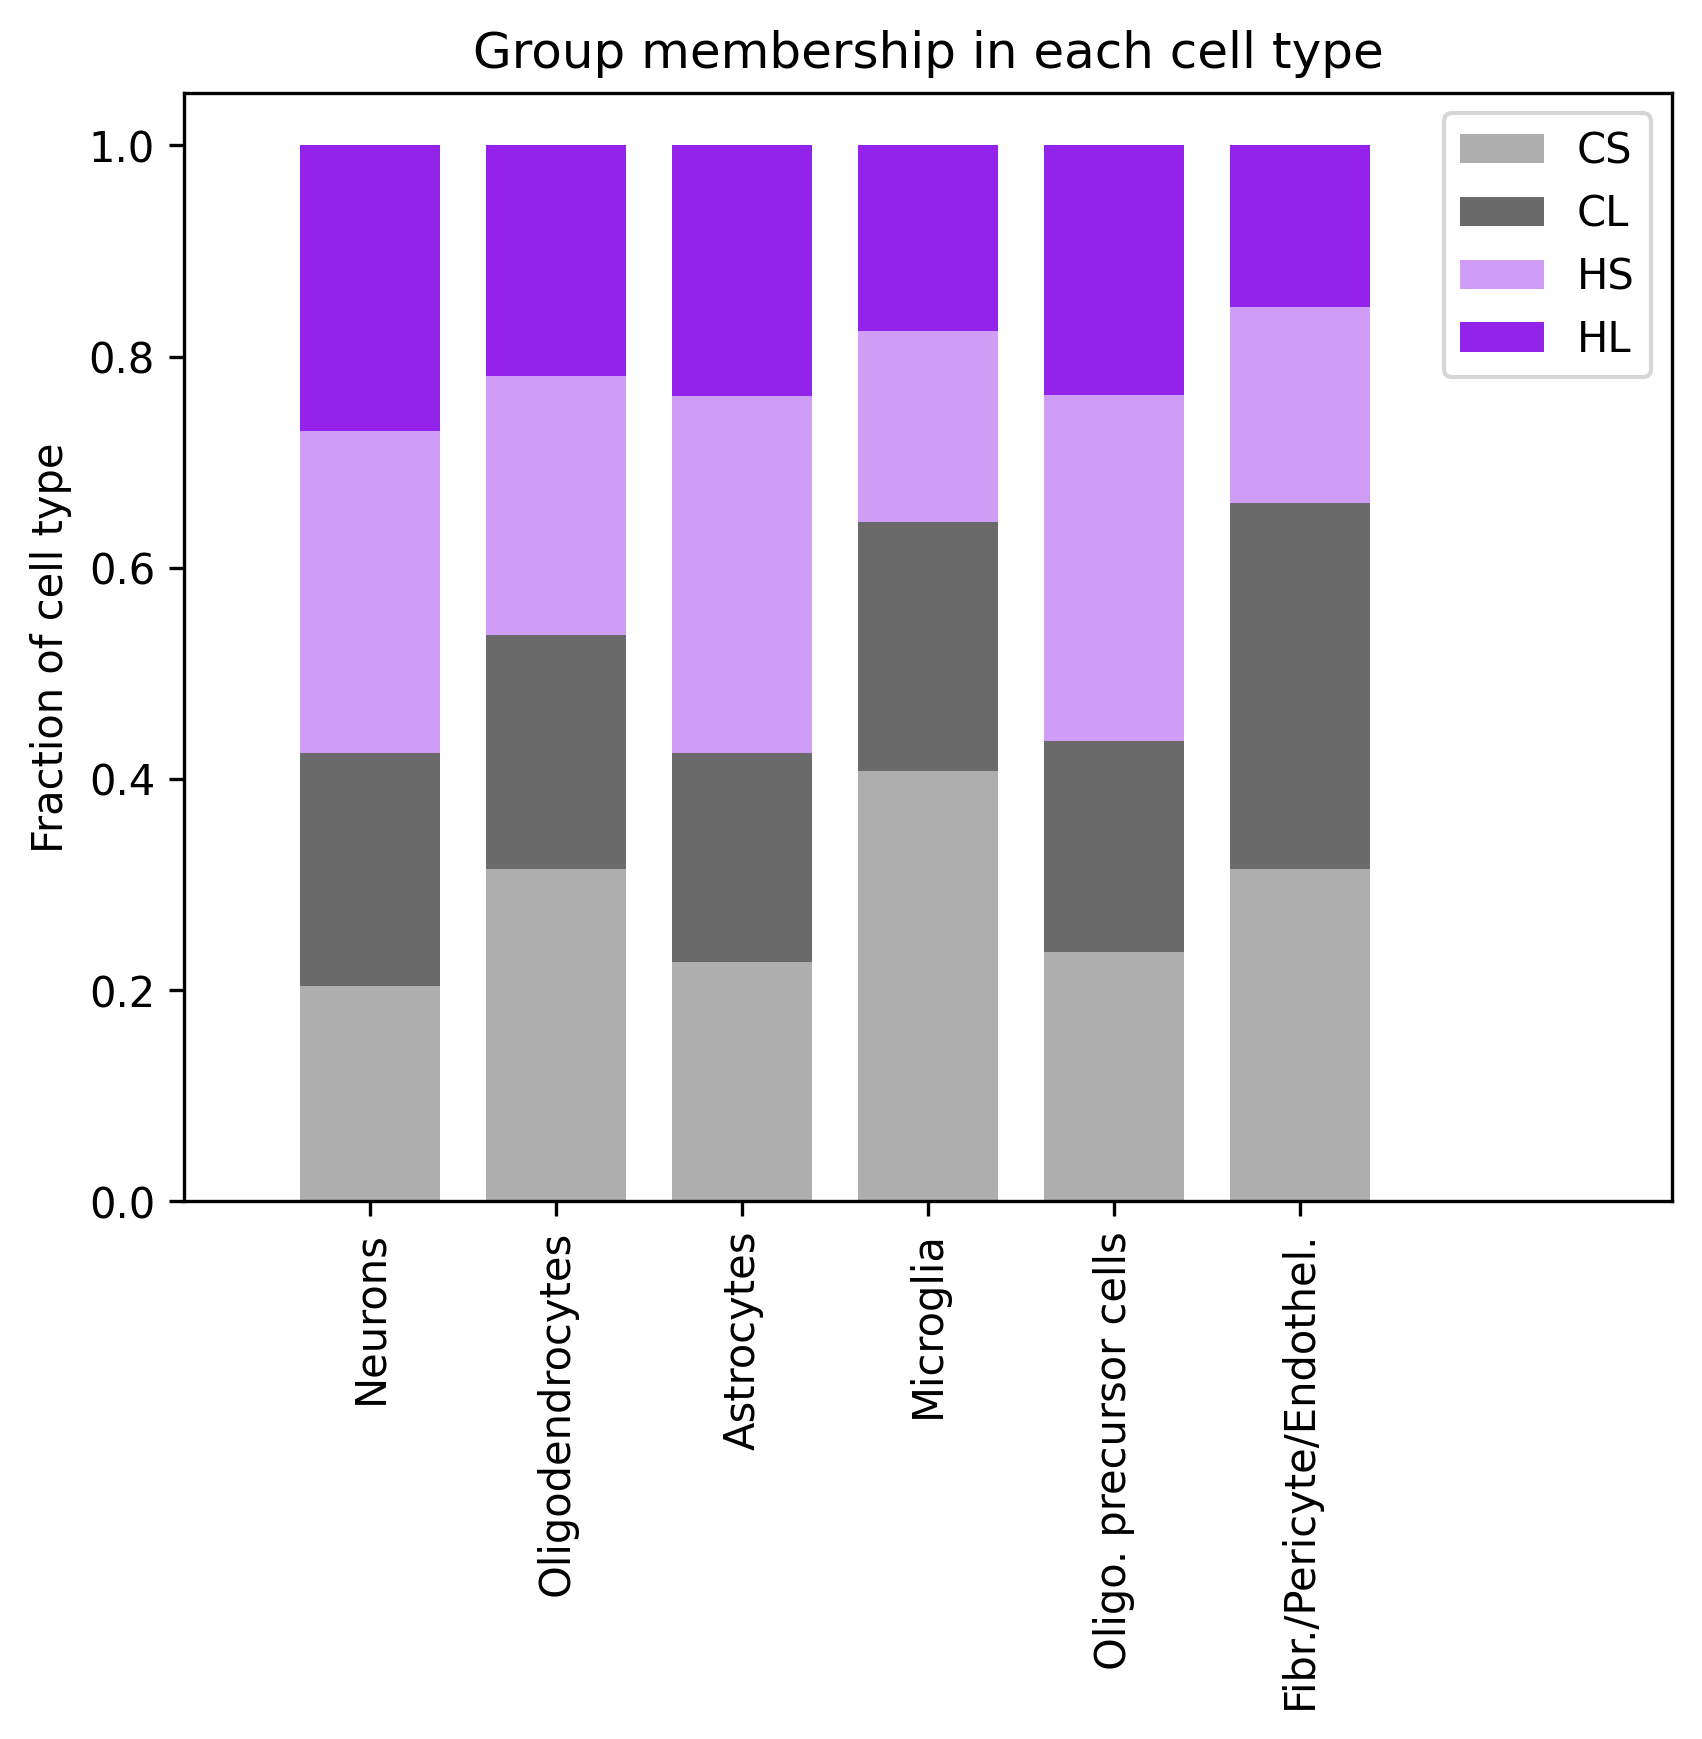

In [64]:
#plot fraction of each cell type from each batch
order = ['Neurons','Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells',
         'Fibr./Pericyte/Endothel.']

groups = ['CS','CL','HS','HL']

typecount=np.zeros((len(groups),len(order)))
for g in range(0,len(groups)):   
    for t in range(0,len(order)):
        typecount[g,t]=np.sum((adata.obs['celltype']==order[t]) & (adata.obs['Sample']==groups[g]))                   

tcn = np.divide(typecount,np.sum(typecount,axis=0))

width = 0.75

fig, ax = plt.subplots()
bottom = np.zeros(6)

for g in range(0,len(groups)):
    p = ax.bar(order, tcn[g,:], width, label=groups[g], bottom=bottom, color=gpcolors[groups[g]])
    bottom += tcn[g,:]

plt.title('Group membership in each cell type')
ax.legend(loc="upper right")
plt.xlim((-1,7))
plt.xticks(rotation=90)
plt.ylabel('Fraction of cell type')
plt.show()

In [22]:
adata.write_h5ad(directory + '/combined.h5ad')

In [2]:
adata = sc.read_h5ad(directory + '/combined.h5ad')

In [8]:
np.median(adata.obs['n_counts'])

3005.0

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored

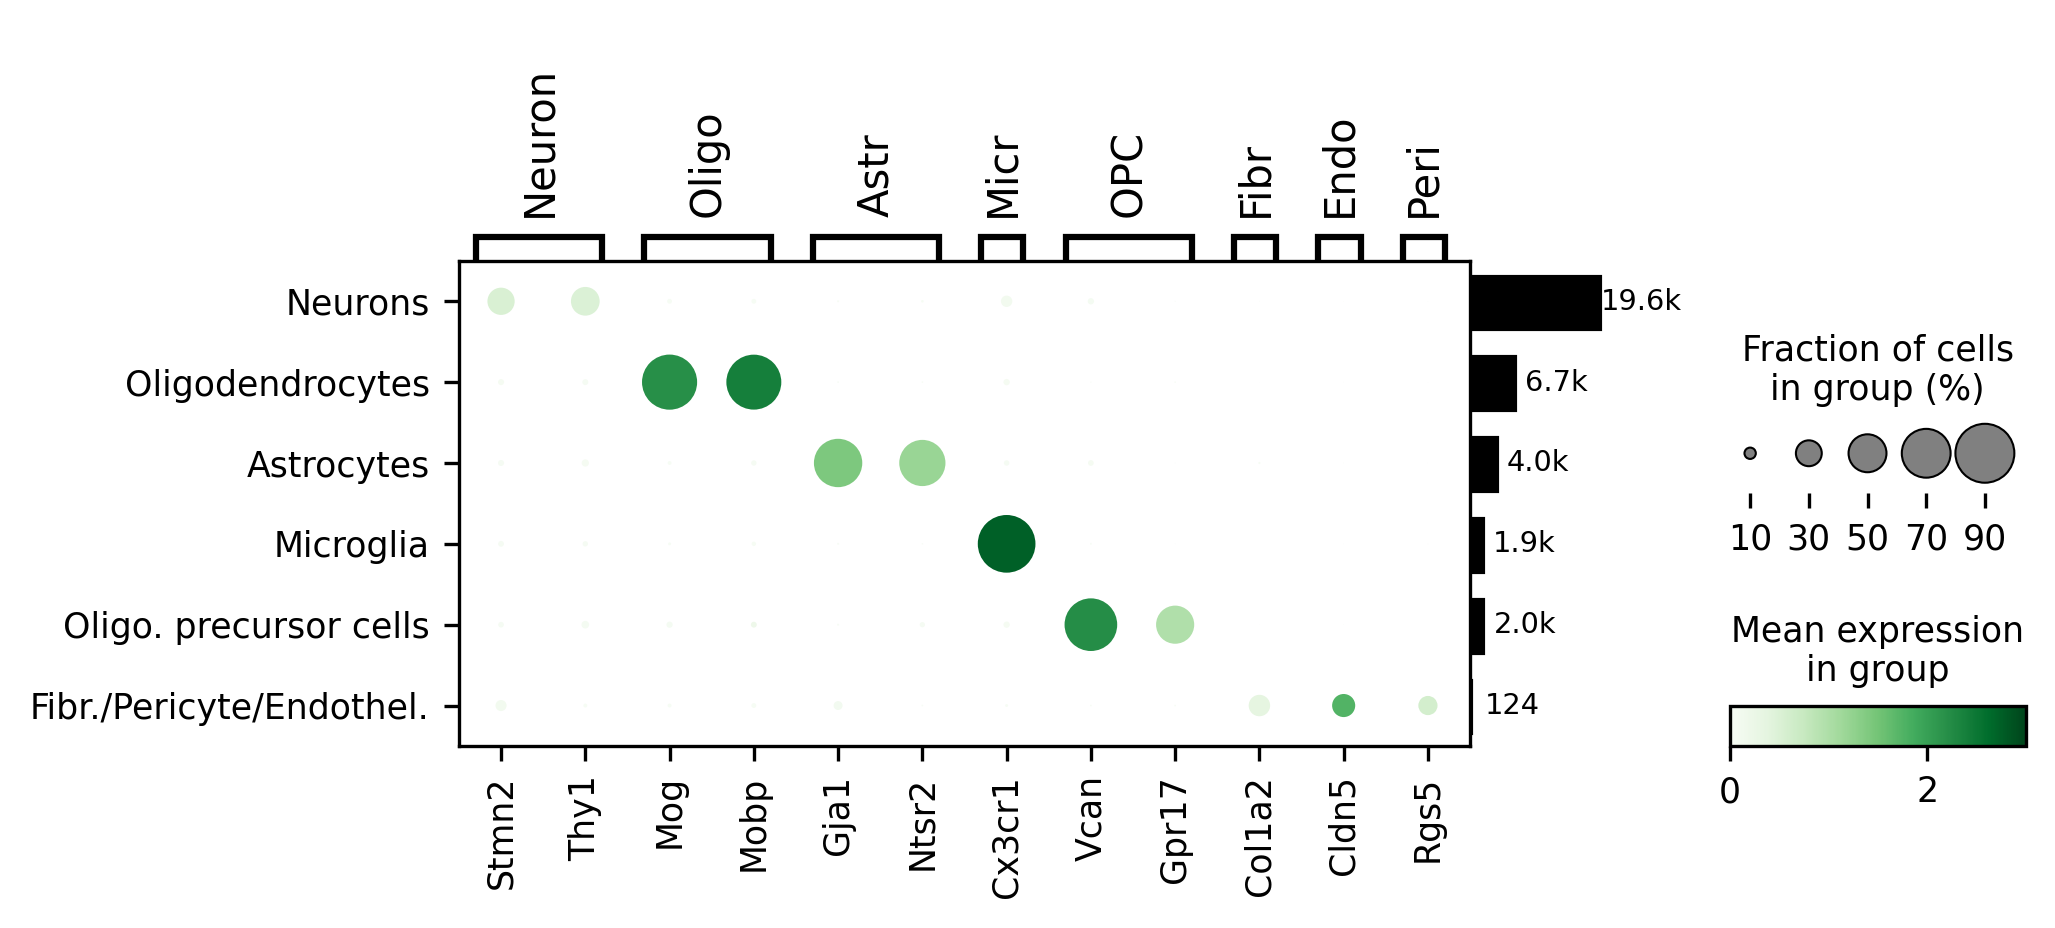

In [66]:
#plot cell-type markers
markers = {'Neuron': {'Thy1','Stmn2'},
           'Oligo': {'Mog','Mobp'},
           'Astr':{'Ntsr2','Gja1'},
           'Micr':{'Cx3cr1'},'OPC': {'Gpr17','Vcan'}, 
           'Fibr':'Col1a2',
           'Endo':'Cldn5','Peri':'Rgs5'}
order = ['Neurons','Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells',
         'Fibr./Pericyte/Endothel.']

dp = sc.pl.dotplot(adata, markers,groupby='celltype',dendrogram=False, return_fig=True, categories_order = order, vmax=3)
dp.add_totals(sort=None, color='black').style(dot_edge_color=None, dot_edge_lw=0.5, cmap='Greens', x_padding=0.5, y_padding=0.5).show()

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-pack

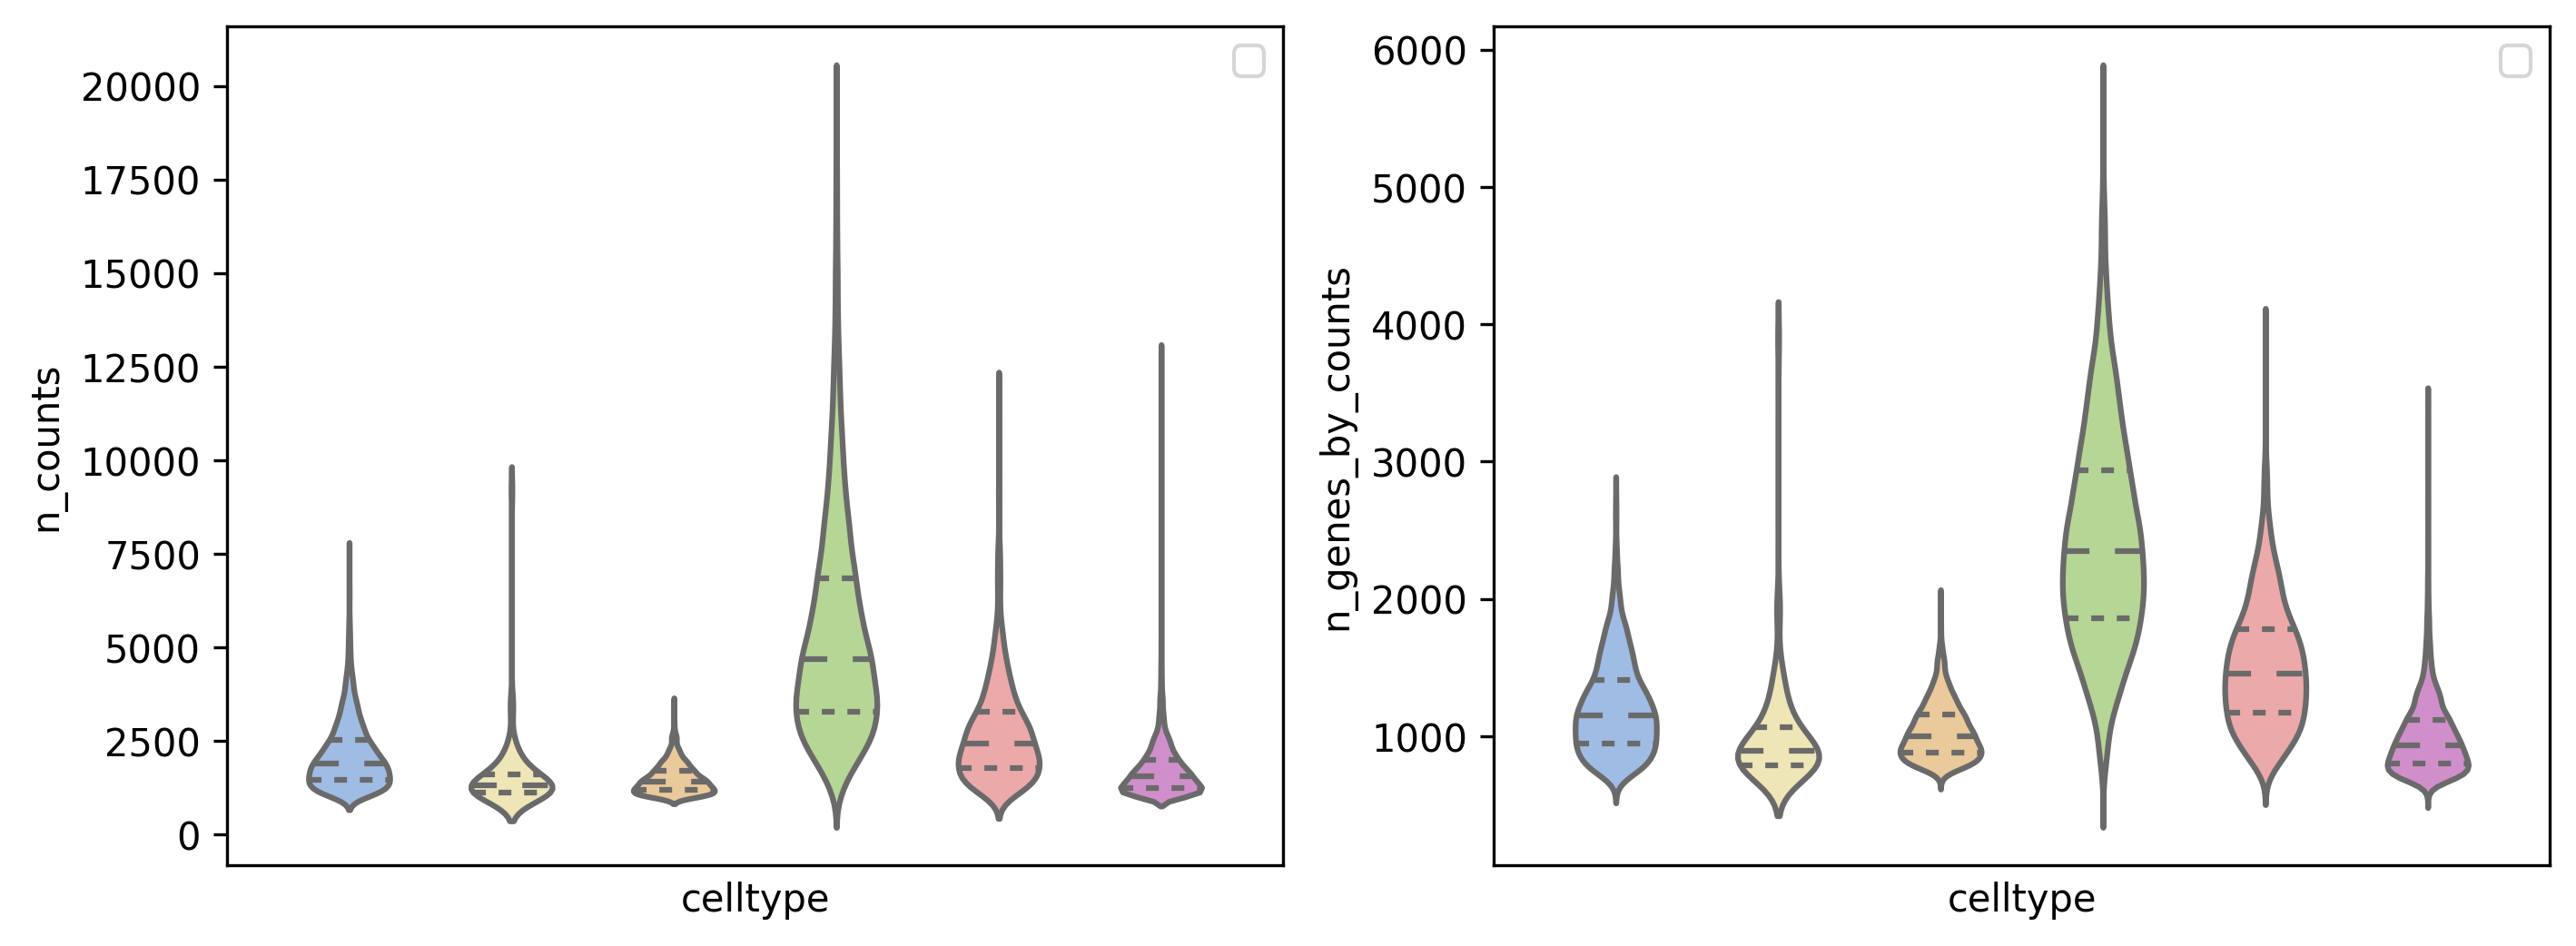

In [67]:
#plot quality metrics
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
sns.violinplot(adata.obs,x='celltype',y='n_counts',hue='celltype',split=False,inner='quart',palette=ctcolors, width=6)
plt.xlim((-4,9))
plt.xticks(())
plt.legend(())

plt.subplot(1,2,2)
sns.violinplot(adata.obs,x='celltype',y='n_genes_by_counts',hue='celltype',split=False,inner='quart',palette=ctcolors, width=6)
plt.xlim((-4,9))
plt.xticks(())
plt.legend(())
plt.savefig(directory + '/Figures/cellsQM.svg')

In [68]:
#only analyze neurons
adata = adata[adata.obs.celltype=='Neurons']
adata.X.shape

(19588, 27809)

In [71]:
#prepare for Map My Cells

In [72]:
#function to create mappings for translating NCBI gene into Ensembl gene
def get_ensembl_mappings():                                   
    # Set up connection to server                                               
    server = biomart.BiomartServer('http://useast.ensembl.org/biomart')         
    mart = server.datasets['mmusculus_gene_ensembl']                            
                                                                                
    # List the types of data we want                                            
    attributes = ['mgi_symbol','ensembl_gene_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    ensembl_to_genesymbol = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        gene_symbol = line[0]                                                   
        ensembl_gene = line[1]                                                  
        ensembl_to_genesymbol[gene_symbol] = ensembl_gene                      
                                                                                
    return ensembl_to_genesymbol

In [73]:
mappings = get_ensembl_mappings()

In [87]:
#get Ensembl names
varlist = adata.var.index.to_numpy()
varlistens = varlist.copy()
include = np.full(len(varlist),False)
gdb = list(mappings.keys())
for x in range(0,len(varlist)):
    if np.isin(varlist[x],gdb):
        varlistens[x]=mappings[varlist[x]]
        include[x]=True

In [95]:
#create smaller anndata with just ens gene and barcodes
adataS = ad.AnnData(adata[:,include].layers['counts'])
adataS.var.index=varlistens[include]
adataS.obs.index=adata.obs.index

In [98]:
adataS.write_h5ad(directory + '/neuronsMMC.h5ad')

In [99]:
#load in results from MMC
mmcdata = pd.read_csv(directory + '/mmc.csv', header=4, index_col=0)

In [102]:
adata.obs['class']=mmcdata['class_name'].astype('category')
adata.obs['subclass']=mmcdata['subclass_name'].astype('category')
adata.obs['supertype']=mmcdata['supertype_name'].astype('category')
adata.obs['cluster']=mmcdata['cluster_name'].astype('category')

In [103]:
adata.obs

,Sample,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden,celltype,class,subclass,supertype,cluster
HS:AAACCCAAGGAGCAAA-1,HS,4501.0,2175,4501.0,7.0,0.155521,22.0,0.488780,0,Neurons,09 CNU-LGE GABA,061 STR D1 Gaba,0270 STR D1 Gaba_6,0958 STR D1 Gaba_6
HS:AAACCCAAGTGCAGGT-1,HS,4874.0,2644,4874.0,9.0,0.184653,16.0,0.328272,0,Neurons,27 MY GABA,285 MY Lhx1 Gly-Gaba,1089 MY Lhx1 Gly-Gaba_1,4854 MY Lhx1 Gly-Gaba_1
HS:AAACCCACAAATCGGG-1,HS,2378.0,1565,2378.0,22.0,0.925147,13.0,0.546678,0,Neurons,11 CNU-HYa GABA,078 SI-MA-ACB Ebf1 Bnc2 Gaba,0365 SI-MA-ACB Ebf1 Bnc2 Gaba_2,1322 SI-MA-ACB Ebf1 Bnc2 Gaba_2
HS:AAACCCACAGCTCGGT-1,HS,2423.0,1571,2423.0,71.0,2.930252,19.0,0.784152,0,Neurons,11 CNU-HYa GABA,086 MPO-ADP Lhx8 Gaba,0406 MPO-ADP Lhx8 Gaba_5,1482 MPO-ADP Lhx8 Gaba_5
HS:AAACCCACAGGGACTA-1,HS,4528.0,2363,4528.0,6.0,0.132509,17.0,0.375442,0,Neurons,09 CNU-LGE GABA,061 STR D1 Gaba,0265 STR D1 Gaba_1,0947 STR D1 Gaba_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CL:TTTGGTTGTCCAGCAC-1,CL,10006.0,3420,10006.0,30.0,0.299820,12.0,0.119928,3,Neurons,11 CNU-HYa GABA,085 SI-MPO-LPO Lhx8 Gaba,0396 SI-MPO-LPO Lhx8 Gaba_1,1419 SI-MPO-LPO Lhx8 Gaba_1
CL:TTTGGTTTCCGTGTAA-1,CL,4589.0,2311,4589.0,16.0,0.348660,9.0,0.196121,3,Neurons,08 CNU-MGE GABA,056 Sst Chodl Gaba,0240 Sst Chodl Gaba_3,0857 Sst Chodl Gaba_3
CL:TTTGTTGAGTCACAGG-1,CL,9684.0,3532,9684.0,66.0,0.681537,15.0,0.154895,3,Neurons,11 CNU-HYa GABA,085 SI-MPO-LPO Lhx8 Gaba,0396 SI-MPO-LPO Lhx8 Gaba_1,1424 SI-MPO-LPO Lhx8 Gaba_1
CL:TTTGTTGCAGACCCGT-1,CL,4049.0,1851,4049.0,5.0,0.123487,16.0,0.395159,9,Neurons,09 CNU-LGE GABA,060 OT D3 Folh1 Gaba,0262 OT D3 Folh1 Gaba_1,0939 OT D3 Folh1 Gaba_1


In [110]:
del(adata.obsm,adata.obsp,adata.uns,adata.obs['n_counts'],adata.obs['leiden'],adata.var['n_cells'])

In [112]:
adata

AnnData object with n_obs × n_vars = 19588 × 27809
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'celltype', 'class', 'subclass', 'supertype', 'cluster'
    layers: 'counts'

In [113]:
adata.write_h5ad(directory + '/neurons.h5ad')